In [274]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [275]:
def Q_integ(y_prev, uu, dt, count):
    K = (.2)**(1/count**count)
    y_new = y_prev + K * (dt) * (uu) / 2
    return y_new

## Lower Limb Exoskeleton Robot 

In [276]:
class exo:
    def __init__(self, dt = 0.01):
        self.t = 0
        self.dt = dt
        self.q = np.zeros([3])
        self.qd = np.zeros([3])
        self.qdd = np.zeros([3])
        self.history = {'q':np.copy(self.q),'qd':np.copy(self.qd),'qdd':np.copy(self.qdd)}
        self.sensor = {'FSR': 0}
    def integrate_euler(self):
        # Euler integration
        self.q = self.q + self.qd * self.dt
        self.qd = self.qd + self.qdd * self.dt
        
    def dynamic(self, q, qd, qdd):
        # Constant values
        m_HK = 3.219
        m_KA = 3.326

        I_HK = 44.57
        I_KA = 51.34

        L_HK = .45
        L_KA = .45

        L_Hm = L_HK / 2
        L_Km = L_KA / 2

        g = 9.81

        # Extract angles and angular velocities
        Teta_H = q[0]
        Teta_K = q[1]

        Teta_H_d = qd[0]
        Teta_K_d = qd[1]

        # Function calls for EXO_M, EXO_C, and EXO_G need to be defined with the correct parameters in Python
        M = self.EXO_M(I_HK, I_KA, L_HK, L_Hm, L_Km, Teta_K, m_HK, m_KA)
        C = self.EXO_C(L_HK, L_Km, Teta_K, Teta_H_d, Teta_K_d, m_KA)
        G = self.EXO_G(L_HK, L_Hm, L_Km, Teta_H, Teta_K, g, m_HK, m_KA)

        # Jacobian matrix
        J = np.array([
            [45 * np.cos(Teta_H) - 45 * np.sin(Teta_H - Teta_K), -45 * np.sin(Teta_H - Teta_K),0],
            [45 * np.sin(Teta_H) + 45 * np.cos(Teta_H - Teta_K),  45 * np.cos(Teta_H - Teta_K),0],[0,0,0]
        ])
        return M, C, G, J
    def run(self, tau):
        M, C, G, J = self.dynamic(self.q, self.qd ,self.qdd)

        F_GR = 2*np.array([(1 - np.cos(.1 * self.t)), (1 + np.sin(.1 * self.t)),0])*0

        # Calculate acceleration 
        # tau needs to be defined, it is the control input
        
        self.history = {'q':np.copy(self.q),'qd':np.copy(self.qd),'qdd':np.copy(self.qdd)}

        f_ = np.linalg.pinv(M) @(- C @ self.qd - G - J.T @ F_GR)#C @ self.qd + G + J.T @ F_GR #
        g_ = np.linalg.pinv(M)#M #
        # self.qdd = g_@tau+f_

        self.qdd = np.linalg.pinv(M) @ (tau - C @ self.qd - G - J.T @ F_GR)
        self.t += self.dt
        count = int(self.t/self.dt)
        self.qd = Q_integ(self.qd, self.qdd + self.history['qdd'], self.dt, count)
        self.q = Q_integ(self.q, self.qd + self.history['qd'], self.dt, count)
        


        # tau = np.linalg.pinv(g_)@(r2d[i+1]-f_)
        # self.integrate_euler()
        return(f_, g_)



    def EXO_M(self, I_HK, I_KA, L_HK, L_Hm, L_Km, Teta_K, m_HK, m_KA):
        # Symbolic expressions
        t2 = np.sin(Teta_K)
        t3 = L_Km**2
        t4 = m_KA * t3
        t5 = L_HK * L_Km * m_KA * t2
        t6 = I_KA + t4 + t5

        # Mass matrix calculation
        M = np.zeros([3, 3])  
        M[0, 0] = I_HK + t5 + t6 + L_Hm**2 * m_HK + L_HK**2 * m_KA
        M[0, 1] = t6
        M[1, 0] = t6
        M[1, 1] = I_KA + t4

        return M 
    def EXO_C(self, L_HK, L_Km, Teta_K, Teta_H_d, Teta_K_d, m_KA):
        t2 = np.cos(Teta_K)
        C_val = L_HK * L_Km * m_KA * t2

        # Coriolis and centrifugal matrix calculation
        C = np.zeros([3, 3]) 
        C[0, 0] = C_val * Teta_K_d * 2.0
        C[0, 1] = -C_val * Teta_H_d * 2.0
        C[1, 0] = C_val * (Teta_H_d - Teta_K_d) * 2.0

        return C
    def EXO_G(self, L_HK, L_Hm, L_Km, Teta_H, Teta_K, g, m_HK, m_KA):
        t2 = np.sin(Teta_H)
        t4 = Teta_H - Teta_K
        t5 = np.cos(t4)

        # Gravity vector calculation
        G = np.array([
            g * (L_Hm * m_HK * t2 + L_HK * m_KA * t2 + L_Km * m_KA * t5),
            L_Km * g * m_KA * t5,
            0.0
        ])
        
        return G
    def reset(self):
        pass

## Adaptive Passivity Based Controller

In [277]:
class APC:
    def __init__(self,const=.1, const2=.1, gam=50, dt = 0.01):
        self.const = const
        self.const2 = const2
        self.gam = gam
        self.dt = dt
        self.t = 0
        self.theta = np.zeros([10])
        self.theta_dot = np.zeros([10])
        self.history = {'theta':np.copy(self.theta),'theta_dot':np.copy(self.theta_dot)}
    def integrate_euler(self):
        # Euler integration
        self.theta = self.theta + self.theta_dot * self.dt
    def run(self, q_des, q_des_d, q_des_dd, q, qd):
        g = 9.81
        Teta_H = q[0]
        Teta_K = q[1]

        Teta_H_d = qd[0]
        Teta_K_d = qd[1]

        q_tilde = q - q_des
        q_tilde_d = qd - q_des_d

        # const = .5
        gamma = self.const * np.eye(3)  # gamma is a 3x3 matrix since it's multiplied by 3-element vectors
        v = q_des_d - gamma @ q_tilde
        vd = q_des_dd - gamma @ q_tilde_d
        r = qd - v

        Teta_H_dd = vd[0]
        Teta_K_dd = vd[1]

        v1 = v[0]
        v2 = v[1]

        vd1 = vd[0]
        vd2 = vd[1]

        qd1 = qd[0]
        qd2 = qd[1]

        # Parameters
        m_HK = 3.219
        m_KA = 3.326

        I_HK = 44.57
        I_KA = 51.34

        L_HK = 0.45
        L_KA = 0.45

        L_Hm = L_HK / 2
        L_Km = L_KA / 2

        # Y matrix
        Y = np.array([
            [vd1, Teta_K_d * qd2 * np.cos(Teta_K), vd2 * np.sin(Teta_K), vd2, v1, qd1, Teta_K_dd, Teta_K_dd * np.sin(Teta_K), Teta_K_d * v2 * np.cos(Teta_K), Teta_H_dd],
            [0, Teta_H_d * qd1 * np.cos(Teta_K), vd1 * np.sin(Teta_K), vd2, v2, qd2, Teta_K_dd, Teta_H_dd * np.sin(Teta_K), Teta_H_d * v1 * np.cos(Teta_K), 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        ])

        # gam = 50
        # print(np.linalg.pinv(gam * Y.T).shape)
        # print(r.shape)
        self.history = {'theta':np.copy(self.theta),'theta_dot':np.copy(self.theta_dot)}
        self.theta_dot = -1/self.gam * Y.T @ r#np.linalg.pinv(gam)

        # const2 = 2  # const2 calculation based on the comment; replace if needed
        K = self.const2 * np.eye(3)
        tau = Y @ self.theta - K @ r

        self.t += self.dt
        count=int(self.t/self.dt)
        self.theta = Q_integ(self.theta, self.theta_dot + self.history['theta_dot'], self.dt, count)
        
        # self.integrate_euler()
        return tau#np.clip(tau,-3000,3000)


In [278]:
# dk = 0.1
# dt = 0.1
# ct33 = 81.087451 / 1000000
# k = np.arange(0, 100 + dk, dk)
# y = np.array([0, 0]+[0]*(len(k)-1))
# pi = np.pi
# r = 1 * pi/18 * np.sin(2 * pi * k / 4/8)
# rd = 1 * pi/18 * pi * np.cos(2 * pi * k / 4/8) / 2/8
# r2d = -1 * pi/18 * pi**2 * np.sin(2 * pi * k / 4/8) / 4/8**2

# r = np.repeat(np.expand_dims(r,1),3,axis=1)*40
# rd = np.repeat(np.expand_dims(rd,1),3,axis=1)*400
# r2d = np.repeat(np.expand_dims(r2d,1),3,axis=1)*400

### Make Reference Data

In [279]:
import scipy.io as sc
temp1 = sc.loadmat('Data1.mat')
r = temp1['data']['Y'][0][0]
r = np.concatenate((r, np.zeros([r.shape[0],1])),1)
dt = 0.01
# r = r[0:3000]
r = r[260000:263000]
r = r/180*np.pi
# r = (r-r.min())/(r.max()-r.min())
rd = np.zeros(r.shape)
r2d = np.zeros(r.shape)
for i in tqdm(range(r.shape[0]-1)):
    rd[i+1] = (r[i+1] - r[i])/dt
    r2d[i+1] = (rd[i+1] - rd[i])/dt

100%|██████████| 2999/2999 [00:00<00:00, 167105.74it/s]


### Control Cycle

In [280]:
dk = 0.01
Full_time = 20
k = np.linspace(0,20, r.shape[0])#np.arange(0, Full_time + dk, dk)
y = np.array([0, 0]+[0]*(len(k)-1))
# r = 60 * np.pi/18 * np.sin(2 * np.pi * k / 4)
# r = np.repeat(np.expand_dims(r,1),3,axis=1)
# r[:,1] = -r[:,1]
# r[:,2] *=0
robot = exo(dt)
# APC_controller = APC(const=20, const2=5, gam=50, dt=dt)
APC_controller = APC(const=1.25, const2=300, gam=1000, dt=dt)  #const=20*4/2**6, const2=5*4*2**6, gam=1000
robot.q = r[0]
q = [robot.q]
tau_hist = [[0,0,0]]
tau_hist2_APC = [[0,0,0]]
window = 20
# robot.qd = rd[0]
# robot.qdd = r2d[0]
for i in range(r.shape[0]-1):
    tau = APC_controller.run(r[i+1], rd[i+1], np.clip(r2d[i+1],-1,1), robot.q, robot.qd) #np.clip(r2d[i+1],-100,100)
    tau_hist.append(tau.tolist())
    if i>=window:
        tau = np.array([pd.Series(np.array(tau_hist)[-window:,0]).rolling(window).mean().values[-1],pd.Series(np.array(tau_hist)[-window:,1]).rolling(window).mean().values[-1],0])
        # tau_hist2[-1] = tau
        tau_hist2_APC.append(tau)
    else:
        tau_hist2_APC.append([0,0,0])
    robot.run(tau)
    q.append(robot.q.tolist())
    
q = np.array(q)
tau_hist = np.array(tau_hist)
tau_hist2_APC = np.array(tau_hist2_APC)

In [281]:
tau_hist.shape, k.shape

((3000, 3), (3000,))

### Plot Results

findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not

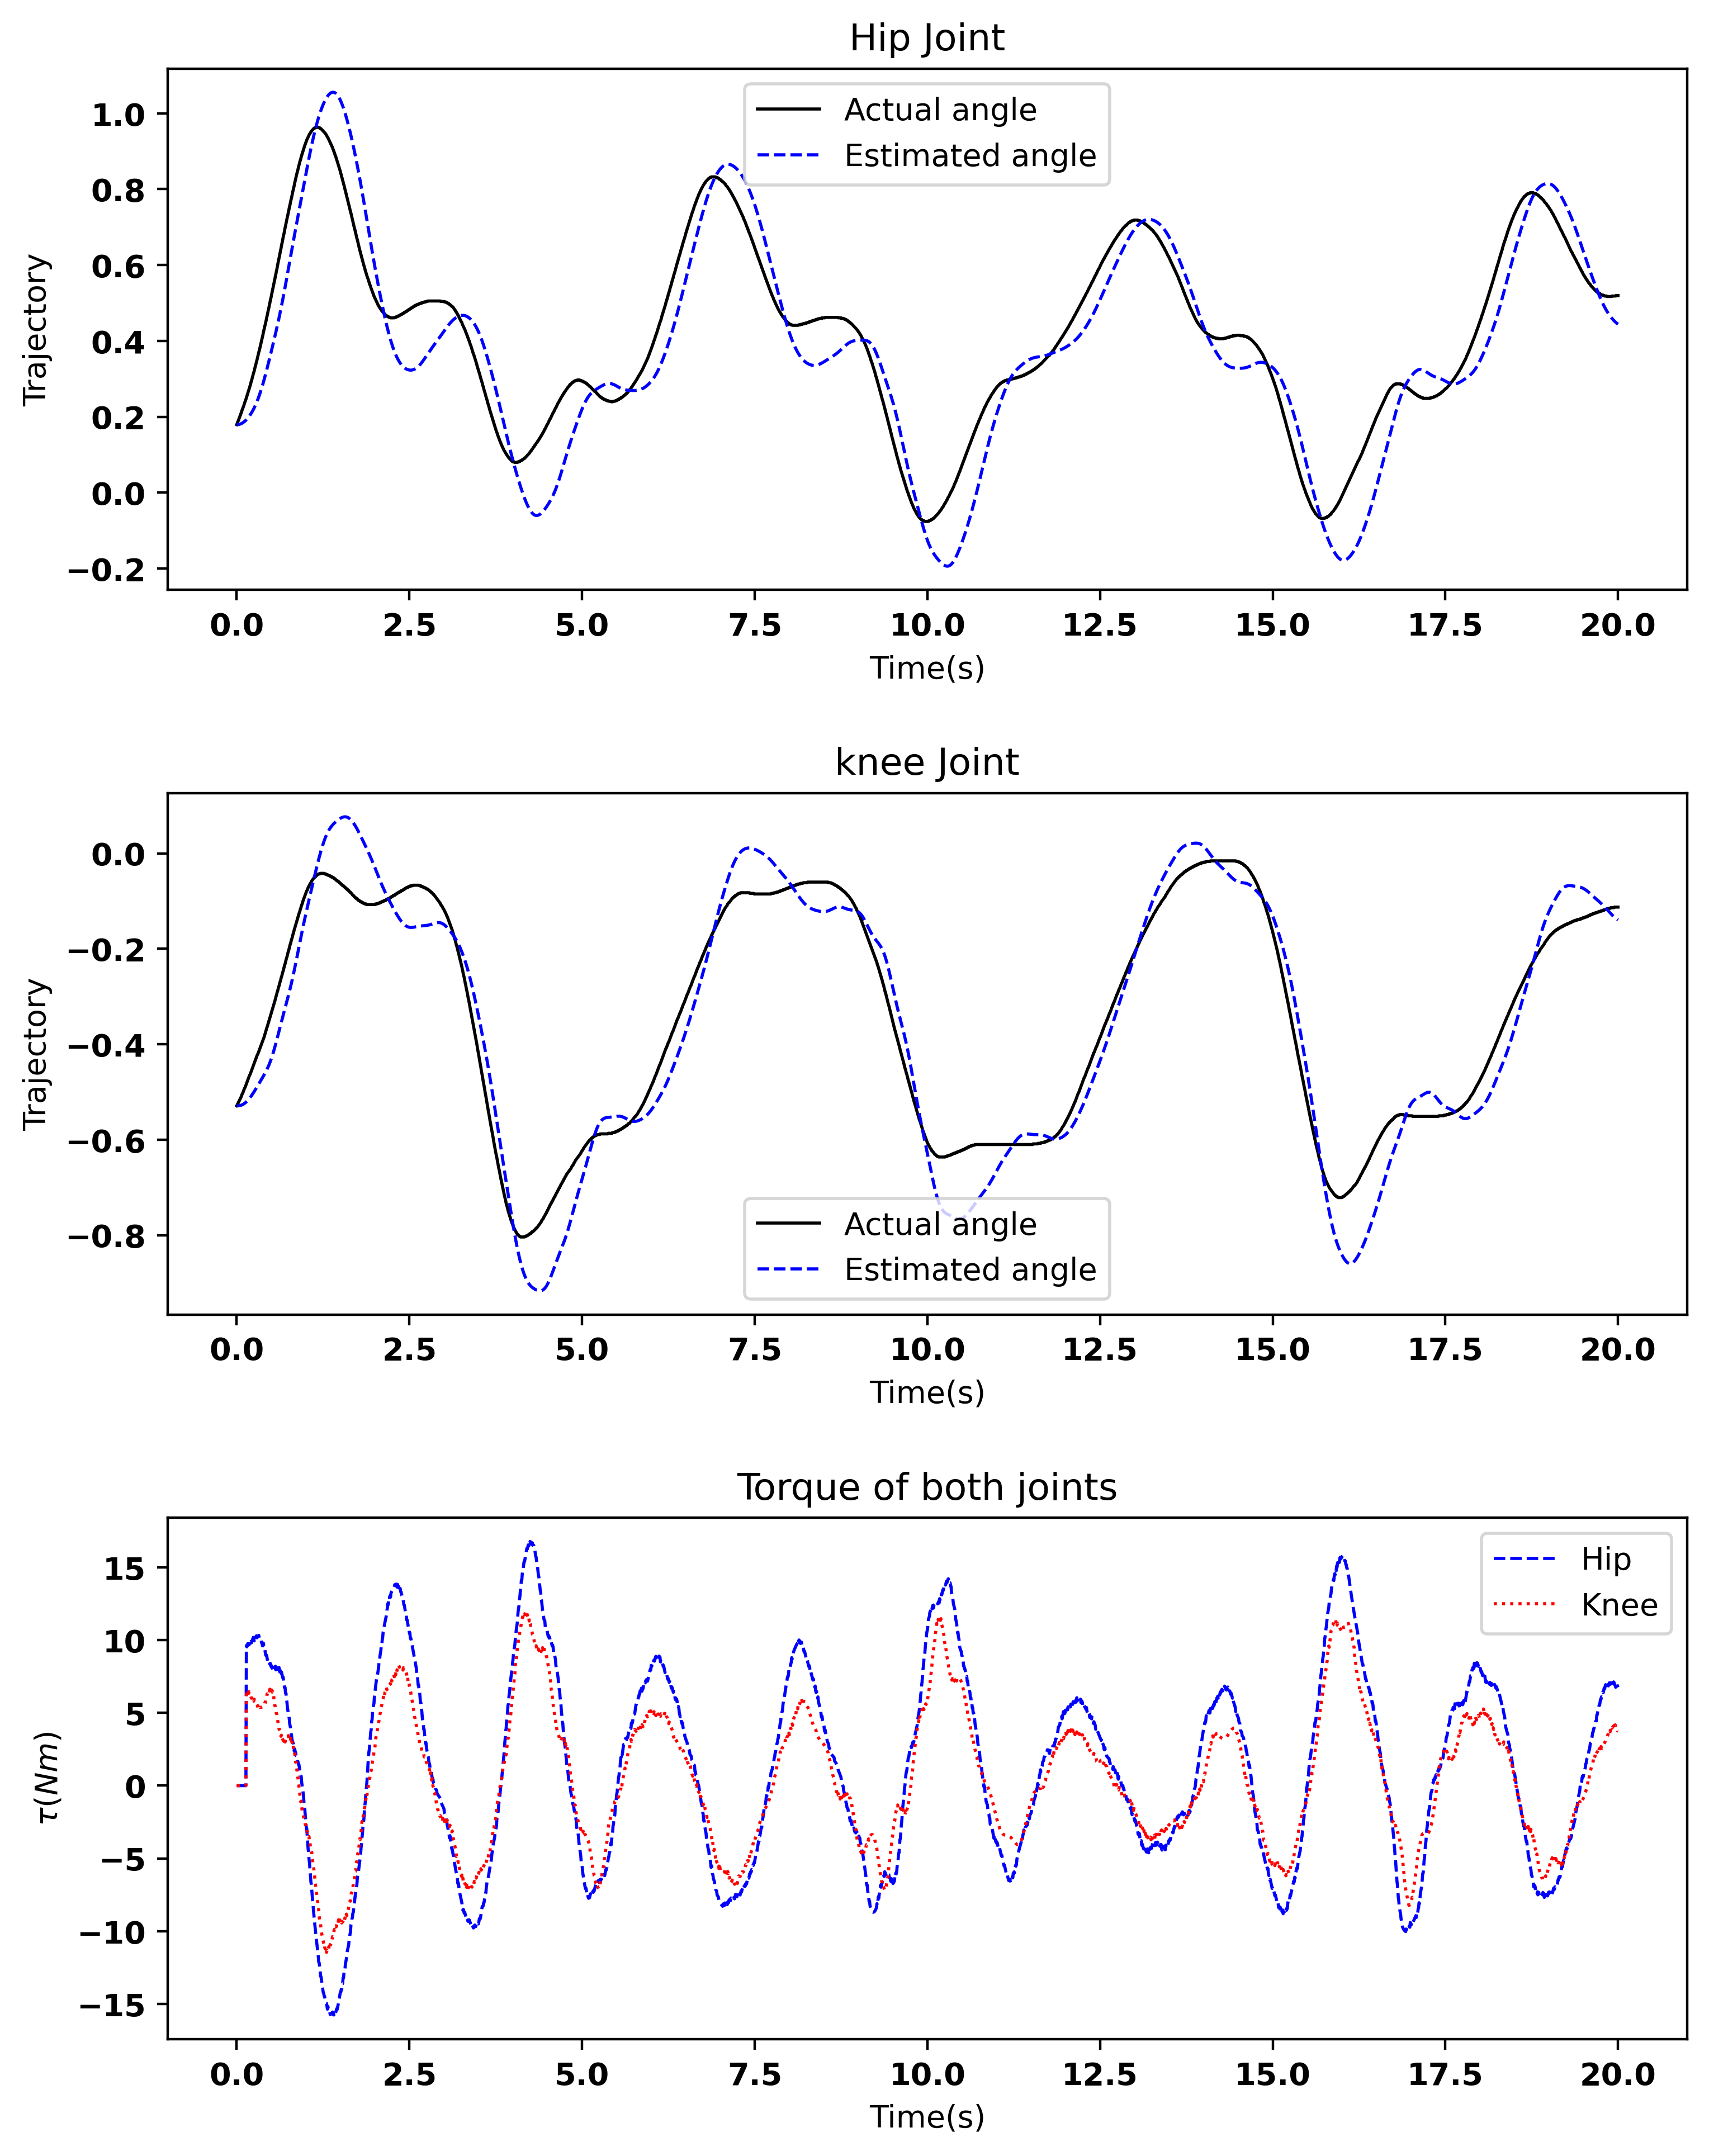

In [282]:
plt.figure(4,figsize=(8, 10), dpi=400)
# First subplot for f
plt.subplot(3, 1, 1)
plt.plot(k, r[:,0], label='Actual angle', linestyle='-', color='black', linewidth=1)
plt.plot(k, q[:,0], label='Estimated angle', linestyle='--', color='blue', linewidth=1)
# plt.plot(k, fh1, label='GFHM', linestyle=':', color='red', linewidth=1)
# plt.plot(k, fh_IT2_TSK, label='IT2-TSK', linestyle='-.', color=[1, 0.6, 0.7843137383461], linewidth=1)
plt.title('Hip Joint')
plt.xlabel('Time(s)')
plt.ylabel('Trajectory')
plt.xticks(fontname='Cambria Math', fontsize=10, fontweight='bold')
plt.yticks(fontname='Cambria Math', fontsize=10, fontweight='bold')
plt.legend()

# First subplot for f
plt.subplot(3, 1, 2)
plt.plot(k, r[:,1], label='Actual angle', linestyle='-', color='black', linewidth=1)
plt.plot(k, q[:,1], label='Estimated angle', linestyle='--', color='blue', linewidth=1)
# plt.plot(k, fh1, label='GFHM', linestyle=':', color='red', linewidth=1)
# plt.plot(k, fh_IT2_TSK, label='IT2-TSK', linestyle='-.', color=[1, 0.6, 0.7843137383461], linewidth=1)
plt.title('knee Joint')
plt.xlabel('Time(s)')
plt.ylabel('Trajectory')
plt.xticks(fontname='Cambria Math', fontsize=10, fontweight='bold')
plt.yticks(fontname='Cambria Math', fontsize=10, fontweight='bold')
plt.legend()

# Second subplot for ef
plt.subplot(3, 1, 3)
plt.plot(k, tau_hist2_APC[:,0]/10, label='Hip', linestyle='--', color='blue', linewidth=1)
plt.plot(k, tau_hist2_APC[:,1]/10, label='Knee', linestyle=':', color='red', linewidth=1)
# plt.plot(k, tau_hist[:,2]/10, label='Ankle', linestyle='-.', color=[1, 0.6, 0.7843137383461], linewidth=1)
plt.title('Torque of both joints')
plt.xlabel('Time(s)')
plt.ylabel(r'$\tau(Nm)$')
# plt.ylim([-0.5, 0.5])
plt.xticks(fontname='Cambria Math', fontsize=10, fontweight='bold')
plt.yticks(fontname='Cambria Math', fontsize=10, fontweight='bold')
plt.legend()

plt.tight_layout(pad=2.0)
plt.savefig('APC.png',dpi=400)